In [57]:
import cantera as ct
import pandas as pd
import numpy as np
import time
import graphviz
import matplotlib.pyplot as plt



In [13]:
# Unit conversions
psi2Pa = 6894.76

In [87]:
# setpoints of engine
OF = 2.1

#mass flow rates [kg/s]
mdot_total = 9 
mdot_lox = mdot_total * (OF/(OF+1))
mdot_kero = mdot_total * (1 / (OF + 1))

# Propellant Temps [K]
T_lox = 90 
T_kero = 298
T_amb = 298

#pressures [Pa]
P_chamber = 500 * psi2Pa 
P_amb = 14.7 * psi2Pa

In [69]:
# kerosene molar ratio
X_kero = {"POSF10325": 1.0}

# lox molar ratio
X_lox = {"O2": 1.0}

In [88]:
# RP-1 reaction mechanism
kerosene = ct.Solution("A2NTC_skeletal.yaml")
kerosene.TPX = T_kero, 800*psi2Pa, X_kero

lox  = ct.Solution("A2NTC_skeletal.yaml")
lox.TPX = T_lox, 800*psi2Pa, X_lox

# arbitrary exhaust 
exhaust = ct.Solution("A2NTC_skeletal.yaml")
exhaust.TP = T_amb, P_amb


In [ ]:
# lox & kero res --(mass flow controllers)-> mixer -> chamber --(Pressure Reg)-> outlet 

# reservoirs
res_lox = ct.Reservoir(lox, name="LOX Reservoir", clone=True)
res_kero= ct.Reservoir(kerosene, name="Kerosene Reservoir", clone=True)
outlet = ct.Reservoir(exhaust, name="Outlet", clone=True)

# reactors 
mixer = ct.IdealGasReactor(kerosene, name="Mixer", clone=True, energy='off')
chamber = ct.ConstPressureReactor(kerosene, name="Chamber", clone=True,  energy='on')

# mass flow controllers
mfc_lox = ct.MassFlowController(upstream= res_lox, downstream= mixer, mdot=mdot_lox, name="LOX Inlet") #lox res to mixer
mfc_kero = ct.MassFlowController(upstream= res_kero, downstream= mixer, mdot=mdot_kero,  name="Kerosene Inlet") #kero res to mixer
mixed_to_chamber = ct.MassFlowController(upstream=mixer, downstream=chamber, mdot=mdot_lox + mdot_kero, name="Mixer to Chamber")

#pressure controllers
pc_outlet = ct.PressureController(upstream=chamber, downstream=outlet, primary=mfc_lox, K=1e-5)

sim = ct.ReactorNet([mixer,chamber])

In [106]:
# lox & kero res --(mass flow controllers)-> mixer -> chamber --(Pressure Reg)-> outlet 

# reservoirs
res_lox = ct.Reservoir(lox, name="LOX Reservoir", clone=True)
res_kero= ct.Reservoir(kerosene, name="Kerosene Reservoir", clone=True)
outlet = ct.Reservoir(exhaust, name="Outlet", clone=True)

# reactors 
chamber = ct.ConstPressureReactor(kerosene, name="Chamber", clone=True,  energy='on')
chamber.TP = 2000, P_chamber

# mass flow controllers
mfc_lox = ct.MassFlowController(upstream= res_lox, downstream= chamber, mdot=mdot_lox, name="LOX Inlet") #lox res to mixer
mfc_kero = ct.MassFlowController(upstream= res_kero, downstream= chamber, mdot=mdot_kero,  name="Kerosene Inlet") #kero res to mixer
#mixed_to_chamber = ct.MassFlowController(upstream=mixer, downstream=chamber, mdot=mdot_lox + mdot_kero, name="Mixer to Chamber")

#pressure controllers
pc_outlet = ct.PressureController(upstream=chamber, downstream=outlet, primary=mfc_lox, K=1e-5)

sim = ct.ReactorNet([chamber])

AttributeError: 'cantera.reactor.ConstPressureReactor' object has no attribute 'TP' and no __dict__ for setting new attributes

In [107]:
# Create a SolutionArray to store the data
time_history = ct.SolutionArray(exhaust, extra=["t"])

# Set the maximum simulation time
max_simulation_time = 50  # seconds

# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while t < max_simulation_time:
    t = sim.step()

    # We will store only every 10th value.
    if counter % 10 == 0:
        # Extract the state of the reactor
        time_history.append(mixer.phase.state, t=t)

    counter += 1

# Stop the stopwatch
toc = time.time()

print(f"Simulation Took {toc-tic:3.2f}s to compute, with {counter} steps")

CanteraError: 
*******************************************************************************
CanteraError thrown by CVodesIntegrator::step:
CVodes error encountered. Error code: -10
Exceptions caught during RHS evaluation:

*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 1131495309.9152427
	Current Pressure        = 5515808
	Starting Temperature    = 716.8022012680623
	Current Temperature     = 8455.111298558102
	Current Enthalpy        = 18034375.90350484
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.111298558102
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 20828111.311931916
	Current Pressure        = 5515808
	Starting Temperature    = 716.8022379511757
	Current Temperature     = 8355.11171671094
	Current Enthalpy        = 18019655.84819551
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.11171671094
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -948373.3839059743
	Current Pressure        = 5515808
	Starting Temperature    = 53.42169555712173
	Current Temperature     = 2.49750470952807e-236
	Current Enthalpy        = -848337.5076713568
	Current Delta T         = -4.99500941905614e-236
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -2809848853.343448
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021056773148
	Current Temperature     = 2.3418056025731412e-234
	Current Enthalpy        = -848337.0343437736
	Current Delta T         = -4.6836112051462825e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 120595117.52594267
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021712311775
	Current Temperature     = 8455.111268521217
	Current Enthalpy        = 18034374.14626578
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.111268521217
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -1176975.1616741554
	Current Pressure        = 5515808
	Starting Temperature    = 353.91712353387
	Current Temperature     = 4.003714666502885e-236
	Current Enthalpy        = -848336.872191482
	Current Delta T         = -8.00742933300577e-236
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 9655313712.806192
	Current Pressure        = 5515808
	Starting Temperature    = 716.802102126986
	Current Temperature     = 8355.110436477571
	Current Enthalpy        = 18019645.645523377
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110436477571
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 118277423.27807626
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021379183575
	Current Temperature     = 8455.11085373867
	Current Enthalpy        = 18034371.97204204
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.11085373867
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 20622236.750589125
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021293809087
	Current Temperature     = 8455.110845201221
	Current Enthalpy        = 18034372.503054723
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110845201221
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -868713.815234011
	Current Pressure        = 5515808
	Starting Temperature    = 411.58195396214484
	Current Temperature     = 8.285722166069404e-236
	Current Enthalpy        = -848337.0824307144
	Current Delta T         = -1.6571444332138808e-235
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 288045942.6875213
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021276463759
	Current Temperature     = 8455.11084346669
	Current Enthalpy        = 18034371.1232305
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.11084346669
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 39619325.3767462
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021305983846
	Current Temperature     = 8455.110846418698
	Current Enthalpy        = 18034371.955216695
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110846418698
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -1484220.670078921
	Current Pressure        = 5515808
	Starting Temperature    = 169.71300644131412
	Current Temperature     = 2.49750470952807e-236
	Current Enthalpy        = -848337.0441640153
	Current Delta T         = -4.99500941905614e-236
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 64485131.699196845
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021234063066
	Current Temperature     = 8455.11083922662
	Current Enthalpy        = 18034371.22393884
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.11083922662
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -1789278.9216938901
	Current Pressure        = 5515808
	Starting Temperature    = 1185.6445758913676
	Current Temperature     = 4.172595690541571e-232
	Current Enthalpy        = -848337.0081289998
	Current Delta T         = -8.345191381083142e-232
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 1057676399.3256944
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020993530984
	Current Temperature     = 8355.110433703685
	Current Enthalpy        = 18019645.436544206
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110433703685
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 96170297.46577011
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021135014199
	Current Temperature     = 8455.110829321733
	Current Enthalpy        = 18034370.42407951
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110829321733
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 19468328.46236189
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021004755315
	Current Temperature     = 8455.110816295844
	Current Enthalpy        = 18034370.697102584
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110816295844
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -4834750.865599714
	Current Pressure        = 5515808
	Starting Temperature    = 166.66915405129797
	Current Temperature     = 2.49750470952807e-236
	Current Enthalpy        = -848337.0319619564
	Current Delta T         = -4.99500941905614e-236
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 54739983.12228318
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021078227514
	Current Temperature     = 8455.110823643063
	Current Enthalpy        = 18034370.30977147
	Current Delta T         = 100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110823643063
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -11328081.719889479
	Current Pressure        = 5515808
	Starting Temperature    = 7512.754437156169
	Current Temperature     = 3.1677444181782594e-228
	Current Enthalpy        = -848336.9936920585
	Current Delta T         = -6.335488836356519e-228
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 896496910.3113014
	Current Pressure        = 5515808
	Starting Temperature    = 716.80210424019
	Current Temperature     = 8355.110438590777
	Current Enthalpy        = 18019645.04166307
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110438590777
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 100353683.89834888
	Current Pressure        = 5515808
	Starting Temperature    = 716.8021024273293
	Current Temperature     = 8355.110436777915
	Current Enthalpy        = 18019645.87642843
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110436777915
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 20907482.896227878
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020866247934
	Current Temperature     = 8355.11042097538
	Current Enthalpy        = 18019646.076522034
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.11042097538
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -898780.1190597925
	Current Pressure        = 5515808
	Starting Temperature    = 46.50305382283831
	Current Temperature     = 2.49750470952807e-236
	Current Enthalpy        = -848337.0375135321
	Current Delta T         = -4.99500941905614e-236
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -1551984.1595087461
	Current Pressure        = 5515808
	Starting Temperature    = 48.63111369663735
	Current Temperature     = 2.49750470952807e-236
	Current Enthalpy        = -848337.0280388257
	Current Delta T         = -4.99500941905614e-236
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 27587997.814432606
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020894589022
	Current Temperature     = 8355.110423809489
	Current Enthalpy        = 18019645.944188286
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110423809489
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 47858444.13458207
	Current Pressure        = 5515808
	Starting Temperature    = 149.65373733451776
	Current Temperature     = 8355.11028137207
	Current Enthalpy        = 18019644.872677963
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.11028137207
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 84133639.07477501
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020985291768
	Current Temperature     = 8355.110432879763
	Current Enthalpy        = 18019645.570457708
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110432879763
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = 96768388.67030555
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 8355.110432579251
	Current Enthalpy        = 18019645.72513806
	Current Delta T         = -100
	  - The phase became unstable (Cp < 0) T_unstable_last = 8455.110432579251
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -856738.5624381946
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0309165174
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857558.2857460837
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0312600838
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857615.30070061
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313458204
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857620.9281386473
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313672449
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857621.8053039872
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313726004
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857621.9916362569
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313739391
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0361616736
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313742738
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0471644603
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743574
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0499071223
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743785
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0505922855
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743836
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.050763545
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.031374385
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0508063578
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743851
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0508170609
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743853
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0508197367
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743853
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0508204056
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743853
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0508205728
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743853
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


*******************************************************************************
CanteraError thrown by ThermoPhase::setState_HPorUV (HP):
No convergence in 500 iterations
	Target Enthalpy         = -857622.0508206147
	Current Pressure        = 5515808
	Starting Temperature    = 716.8020982286657
	Current Temperature     = 2.3418054532326158e-234
	Current Enthalpy        = -848337.0313743853
	Current Delta T         = -4.6836109064652315e-234
*******************************************************************************


cvHandleFailure: At t = 6.70341067490968 repeated recoverable right-hand side function errors.
Components with largest weighted error estimates:
0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
*******************************************************************************


In [99]:
df = time_history.to_pandas()
df

,t,T,density,Y_POSF10325,Y_C2H4,Y_CH4,Y_C3H6,Y_iC4H8,Y_C4H81,Y_H2,...,Y_C6H5O,Y_C6H5CO,Y_C6H5CHO,Y_A2C11H21,Y_A2C11H21O2,Y_A2C11H20OOH,Y_A2C11H20,Y_A2C11H21O4,Y_A2C11H20O3,Y_N2


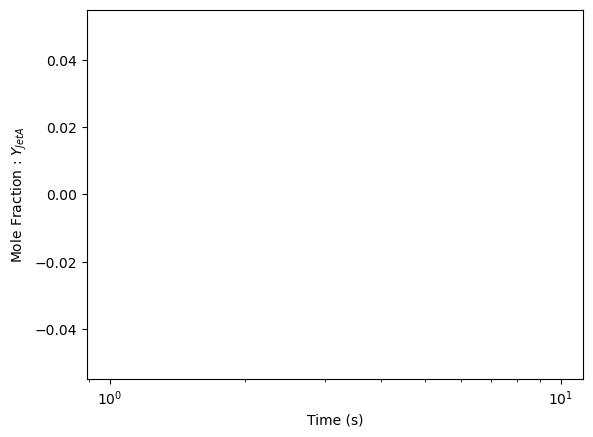

In [101]:
plt.figure()
plt.semilogx(time_history.t, time_history.POSF10325, "-o")
plt.xlabel("Time (s)")
plt.ylabel("Mole Fraction : $Y_{Jet A}$")
plt.show()